In [23]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

print("PyTorch Version:", torch.__version__)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

PyTorch Version: 2.0.1
Using device: cpu


In [24]:
# Hyperparameters and config

# Path to image folder
data_dir = "data/AD_NC/train/AD-parent/"

batch_size = 32

# Factor to reduce the width and height of the images by
dimension_reduce_factor = 2 # downsample factor of 4

# Original dimensions
original_width = 256
original_height = 240

images_input.shape: torch.Size([32, 3, 120, 128])
images_output.shape: torch.Size([32, 3, 240, 256])


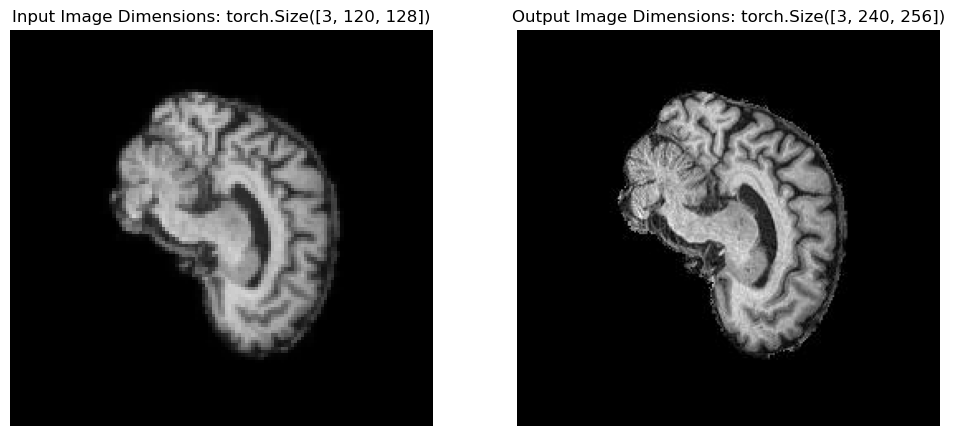

In [26]:
input_transform = transforms.Compose([
    transforms.Resize([
        original_height // dimension_reduce_factor, 
        original_width // dimension_reduce_factor
    ]),
    transforms.ToTensor(),
])

output_transform = transforms.Compose([
    transforms.ToTensor(),
])

input_dataset = ImageFolder(root=data_dir, transform=input_transform)
output_dataset = ImageFolder(root=data_dir, transform=output_transform)

# Create a data loader to iterate through the dataset
input_data_loader = DataLoader(input_dataset, batch_size=batch_size)
output_data_loader = DataLoader(output_dataset, batch_size=batch_size)

for batch_input, batch_output in zip(input_data_loader, output_data_loader):
    # Downsampled images
    images_input, _ = batch_input
    # Original images
    images_output, _ = batch_output

    print('images_input.shape:', images_input.shape)
    print('images_output.shape:', images_output.shape)
    
    # Get the dimensions of the first input image
    first_input_image = images_input[0]
    input_image_dims = first_input_image.shape  # Shape will be (3, 224, 224) for RGB images
    
    # Get the dimensions of the first output image
    first_output_image = images_output[0]
    output_image_dims = first_output_image.shape  # Shape will be (3, 224, 224) for RGB images
    
    # Display the first input image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(first_input_image.permute(1, 2, 0))  # Convert tensor to numpy format (C, H, W) -> (H, W, C)
    plt.title(f"Input Image Dimensions: {input_image_dims}")
    plt.axis('off')  # Turn off axis labels
    
    # Display the first output image
    plt.subplot(1, 2, 2)
    plt.imshow(first_output_image.permute(1, 2, 0))  # Convert tensor to numpy format (C, H, W) -> (H, W, C)
    plt.title(f"Output Image Dimensions: {output_image_dims}")
    plt.axis('off')  # Turn off axis labels
    
    plt.show()
    
    break  # Stop after the first batch to print/display only the first pair of images

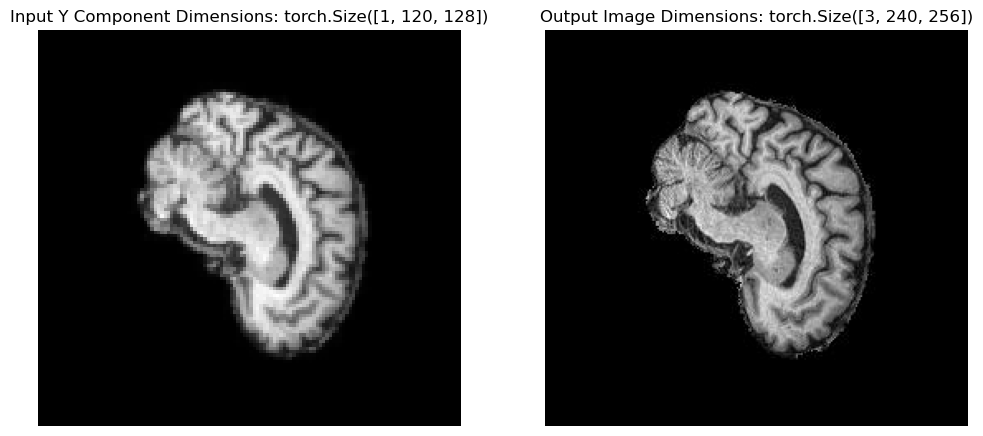

In [29]:
from PIL import Image
import numpy as np

# Now you can iterate through the data loaders to access your images and labels
for batch_input, batch_output in zip(input_data_loader, output_data_loader):
    images_input, _ = batch_input
    images_output, _ = batch_output
    
    # 'images_input' contains the downsampled input images
    # 'images_output' contains the expected output images (unchanged)
    
    # Convert images to YUV color space and retain only the Y component
    yuv_images_input = []
    for image in images_input:
        # Convert PIL Image to YUV
        yuv_image = Image.fromarray(np.uint8(image.permute(1, 2, 0).numpy() * 255))
        yuv_image = yuv_image.convert("YCbCr")
        yuv_image = yuv_image.split()[0]  # Retain only the Y component
        yuv_image = torch.tensor(np.array(yuv_image) / 255.0, dtype=torch.float32).unsqueeze(0)
        yuv_images_input.append(yuv_image)
    
    # Get the dimensions of the first input image
    first_input_image = yuv_images_input[0]
    input_image_dims = first_input_image.shape  # Shape will be (1, 224, 224) for grayscale Y component
    
    # Get the dimensions of the first output image
    first_output_image = images_output[0]
    output_image_dims = first_output_image.shape  # Shape will be (3, 224, 224) for RGB images
    
    # Display the first input image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(first_input_image[0], cmap='gray')  # Display the Y component as grayscale
    plt.title(f"Input Y Component Dimensions: {input_image_dims}")
    plt.axis('off')  # Turn off axis labels
    
    # Display the first output image
    plt.subplot(1, 2, 2)
    plt.imshow(first_output_image.permute(1, 2, 0))  # Convert tensor to numpy format (C, H, W) -> (H, W, C)
    plt.title(f"Output Image Dimensions: {output_image_dims}")
    plt.axis('off')  # Turn off axis labels
    
    plt.show()
    
    break  # Stop after the first batch to print/display only the first pair of images